In [30]:
import re
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from collections import Counter
from matplotlib.patches import Circle
from typing import List, Union, Tuple, Literal

In [241]:
def DMm_to_Dd(s: str, pattern: str) -> float:
    parsed = re.search(pattern=pattern, string=s, flags=re.IGNORECASE)
    D = int(parsed.group(1))
    M = int(parsed.group(2))
    m = parsed.group(3)

    # convert
    m = int(m) / 10**len(m)
    d = (M + m) / 60
    return D + d


def igc_parser(files: Union[str, List[str]], pattern: str = r"B([0-9]{6})([0-9]{7}[N, S])([0-9]{8}[W, E])([A, V])([0-9]{5})([0-9]{5})", 
               lat_pattern: str = r"([0-9]{2})([0-9]{2})([0-9]{3})[N, S]", long_pattern: str = r"([0-9]{3})([0-9]{2})([0-9]{3})[E, W]", 
               offset: int = 0) -> pd.DataFrame:
    if isinstance(files, str):
        files = [files, ]

    points = []
    flight_date = None
    for file in files: 
        
        with open(file, "r") as igc_f:
            for line in igc_f:
                
                if flight_date is None:
                    parsed = re.search(pattern=r"(?:HFDTE|HFDTEDATE:?\s*)([0-9]{6})", string=line.strip(), flags=re.IGNORECASE)
                    if parsed is not None:
                        flight_date = parsed.group(1)
                    continue

                parsed = re.search(pattern=pattern, string=line.strip(), flags=re.IGNORECASE)

                if parsed is not None:
                    utc_time  = parsed.group(1)
                    latitude  = parsed.group(2)
                    longitude = parsed.group(3)
                    validity  = parsed.group(4)
                    press_alt = int(parsed.group(5))
                    gnss_alt  = int(parsed.group(6))

                    # convert latitude and longitude
                    latitude = DMm_to_Dd(latitude, lat_pattern)
                    longitude = DMm_to_Dd(longitude, long_pattern)

                    # get datetime
                    datetime = dt.datetime.strptime(flight_date + utc_time, "%d%m%y%H%M%S") + dt.timedelta(hours=offset)

                    point = (file, datetime, latitude, longitude, validity, press_alt, gnss_alt)
                    points.append(point)
    columns = ["igc_path", "datetime", "latitude", "longitude", "validity", "press_alt", "gnss_alt"]
    points = pd.DataFrame(points, columns=columns)
    return points

In [251]:
# parse igc files
root_dir = "./data/igc/"
igc_files = [os.path.join(root_dir, igc_file) for igc_file in os.listdir(root_dir)]
print("Всего файлов: %s" % len(igc_files))
points = igc_parser(files=igc_files, offset=3)
points = points.sort_values(by=["datetime"], ascending=True).reset_index(drop=True)

print("Всего точек: %s" % len(points))
display(points.head(2))

Всего файлов: 4
Всего точек: 8029


,igc_path,datetime,latitude,longitude,validity,press_alt,gnss_alt
0,./data/igc/flight.igc,2023-05-08 11:15:46,54.66135,37.9686,A,74,205
1,./data/igc/part_1.igc,2023-05-08 11:15:46,54.66135,37.9686,A,74,205


In [252]:
points = points[points["igc_path"] == './data/igc/flight.igc']

In [253]:
points[["latitude", "longitude"]].agg(["min", "max"])

,latitude,longitude
min,54.468550,37.549833
max,54.668317,37.977183


Map latitude from 54.6707 to 54.4628
Map longitude from 37.5156 to 38.0148


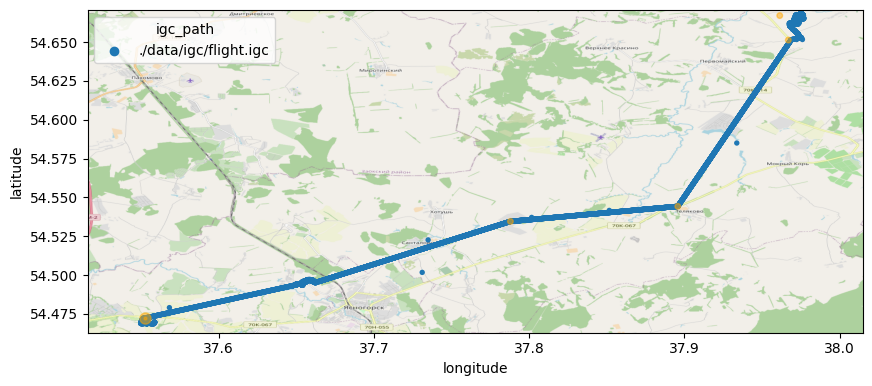

In [254]:
# open map from openstreetmap.org
ruh_m = plt.imread("./data/map.png")

# read map coordinates
with open("./data/map.txt", "r") as f:
    latitude_max, latitude_min, longitude_min, longitude_max = \
        tuple(map(float, f.readline().strip().split()))
print("Map latitude from %s to %s\nMap longitude from %s to %s" % (latitude_min, latitude_max, longitude_min, longitude_max))

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(data=points, x="longitude", y="latitude", hue="igc_path", ax=ax, linewidth=0, s=15)
ax.imshow(ruh_m, zorder=0, extent=(longitude_min, longitude_max, latitude_max, latitude_min), aspect="equal")

# plot task
with open("./data/task.xctsk", "r") as task_f:
    task = json.load(task_f)

for waypoint in task["turnpoints"]:
    radius, waypoint = waypoint["radius"], waypoint["waypoint"]
    lat, lon = waypoint["lat"], waypoint["lon"]
    radius = radius / ((2 * np.pi * 6378.1) / 360)
    circle = Circle((lon, lat), radius / 1000, alpha=0.5, color="orange")
    ax.add_patch(circle)

# ax.set_ylim(54.465, 54.475)
# ax.set_xlim(37.54, 37.56);

In [218]:
task["turnpoints"][3]

{'radius': 200,
 'waypoint': {'lon': 37.7879991,
  'lat': 54.5345033,
  'altSmoothed': 226,
  'name': 'T11SWY',
  'description': 'T11SWY'}}

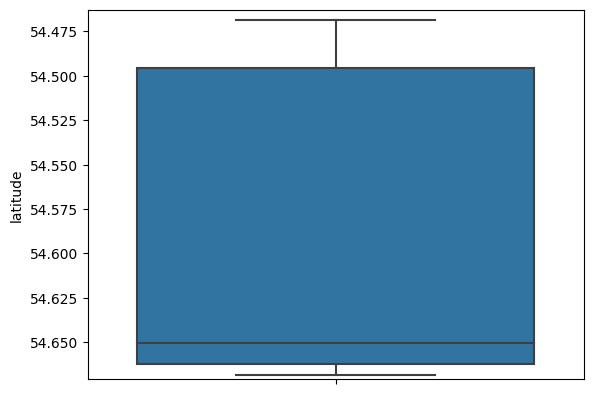

In [196]:
fig, ax = plt.subplots()
sns.boxplot(data=points, y="latitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(latitude_min, latitude_max);

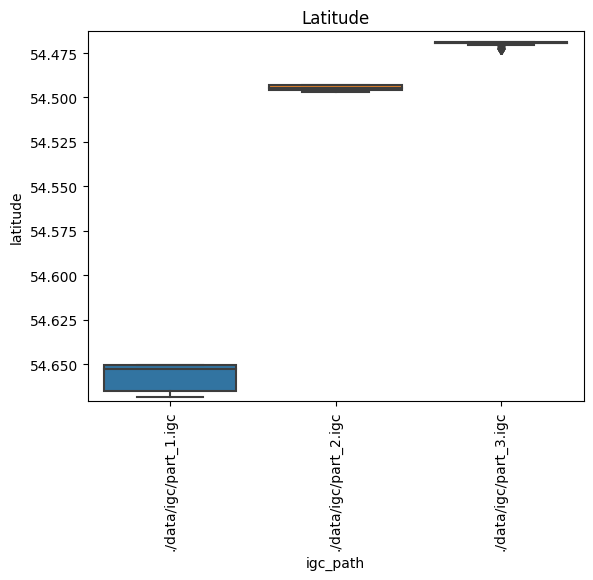

In [197]:
fig, ax = plt.subplots()
sns.boxplot(data=points, x="igc_path", y="latitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(latitude_min, latitude_max)
ax.set_title(label="Latitude");

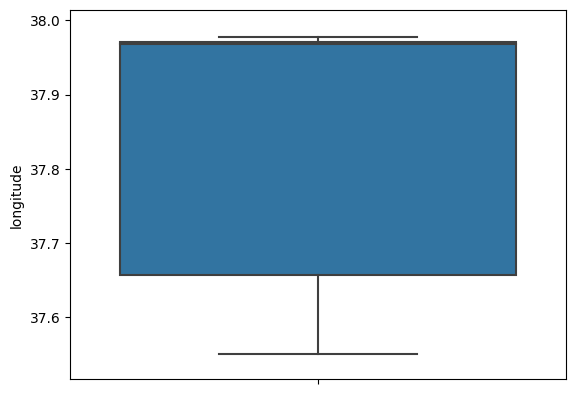

In [198]:
fig, ax = plt.subplots()
sns.boxplot(data=points, y="longitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(longitude_min, longitude_max);

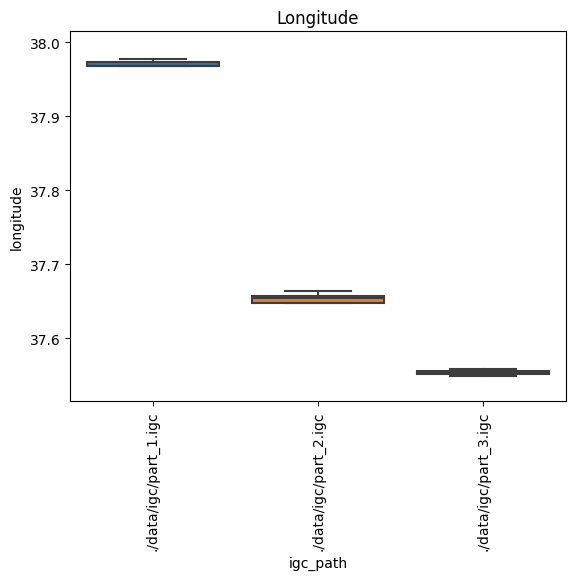

In [200]:
fig, ax = plt.subplots()
sns.boxplot(data=points, x="igc_path", y="longitude", ax=ax)
plt.xticks(rotation=90)
ax.set_ylim(longitude_min, longitude_max)
ax.set_title(label="Longitude");

# Join igc file

In [249]:
class AddPoints:
    def __init__(self, points: List[Tuple]) -> None:
        self.points = points
    
    def __call__(self):
        return pd.DataFrame(self.points, columns=["datetime", "latitude", "longitude", "validity", "press_alt", "gnss_alt"])


def join_points(points: List, header: str, path: str = "flight.igc", offset: int = 3) -> None:
    results = []
    for batch in points:
        if isinstance(batch, str) and os.path.exists(batch):
            parsed = igc_parser(files=batch, offset=offset)
            parsed = parsed[parsed["validity"] == 'A']
            results.append(parsed)
        elif isinstance(batch, AddPoints):
            results.append(batch())
    results = pd.concat(results, ignore_index=True)

    # заполним пропущенные значения
    results = results.interpolate(method="linear", limit_area="inside", axis=0)
    results["datetime"] = results["datetime"].dt.round(freq="1S")
    datetime_min, datetime_max = results["datetime"].agg(["min", "max"])
    print(datetime_min, datetime_max)
    timeline = pd.date_range(start=datetime_min, end=datetime_max, freq="1S")
    results = pd.DataFrame(data={"datetime": timeline}).merge(results, how="left", on="datetime")
    results = results.interpolate(method="linear", limit_area="inside", axis=0)

    results["validity"] = "A"
    results["igc_path"] = results["igc_path"].fillna(value="manualy")
    results = results.sort_values(by="datetime", ascending=True)

    # преобразуем
    results["datetime"]  = (results["datetime"] - pd.Timedelta(hours=offset)).dt.strftime("%H%M%S")
    results["latitude"]  = results["latitude"].transform(Dd_to_DMm,  pattern="DDMMmmm",  char="N")
    results["longitude"] = results["longitude"].transform(Dd_to_DMm, pattern="DDDMMmmm", char="E")
    results["press_alt"] = results["press_alt"].astype("int32").transform(extend, ndigits=5)
    results["gnss_alt"]  = results["gnss_alt"].astype("int32").transform(extend, ndigits=5)

    # сшиваем
    with open(path, "w") as f:
        f.write(header + "\n")
        for _, point in results.iterrows():
            point = "B%s%s%s%s%s%s\n" % (
                point["datetime"], 
                point["latitude"], 
                point["longitude"], 
                point["validity"], 
                point["press_alt"], 
                point["gnss_alt"])
            f.write(point)
    return results


def Dd_to_DMm(value: float, pattern: str, char: str = Literal["N", "S", "W", "E"]) -> float:
    pattern = Counter(pattern)

    # degrees
    D = str(int(value // 1))
    D = extend(value=D, ndigits=pattern.get("D"))

    # minutes
    Mm = value % 1 * 60
    M = str(int(Mm // 1))
    M = extend(value=M, ndigits=pattern.get("M"))
    m = str(int(round(Mm % 1, pattern.get("m")) * 10**pattern.get("m")))
    m = extend(value=m, ndigits=pattern.get("m"))
    return D + M + m + char


def extend(value: str, ndigits: int) -> str:
    if not isinstance(value, str):
        value = str(value)

    add_digits = ndigits - len(value)
    if add_digits > 0:
        value = "0"*add_digits + value
    return value[:ndigits]


# format time %H%M%S, Latitude D.d, Longitude D.d, Validity, Press Alt, GNSS Alt.
ADD_POINTS = [
    (np.datetime64("NaT"), 54.5441995,  37.8958009, "A", np.nan, np.nan),
    (np.datetime64("NaT"), 54.5345033,  37.7879991, "A", np.nan, np.nan),
]

IGC_FILES = [
    "./data/igc/part_1.igc",
    AddPoints(ADD_POINTS),
    "./data/igc/part_2.igc",
    "./data/igc/part_3.igc",
]

ATTR = dict(
    date="080523",  # format time %d%m%y
    pilot="Andrei Makarovskii",
    glider_class="FAI-3",
    glider="BGD Cure 2",
    site="Zhuravli",
)

HEADER = \
"""\
AXGD111 Flymaster F1, V1.5, S/N 2061
HFDTE%s
HOPLTPILOT: %s
HFGTYGLIDERTYPE: %s
HOGIDGLIDERID: None
HODTM100GPSDATUM: WGS-84
HOCIDCOMPETITIONID: 
HOCCLCOMPETITION CLASS: %s
HOSITSite: %s""" % (
    ATTR.get("date"), 
    ATTR.get("pilot"), 
    ATTR.get("glider"), 
    ATTR.get("glider_class"),
    ATTR.get("site"),)

res = join_points(points=IGC_FILES, header=HEADER)

2023-05-08 11:15:46 2023-05-08 12:47:27
